# CS 109B/Data Science: Final Project - Milestone V
**Harvard University**<br>
**Spring 2017**<br>
**Group 33**<br>
**Date: ** May 3, 2017 

In [292]:
%matplotlib inline
import os
import re
import keras
import urllib
import math
import sys
import nltk
import json
import itertools
import scipy as sp
import random
import time

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from unidecode import unidecode
from nltk.corpus import stopwords
from collections import OrderedDict
from collections import Counter
from collections import OrderedDict, Counter

from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
from sklearn.cross_validation import KFold as sk_kfold
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import cross_val_predict
from sklearn.datasets import make_multilabel_classification
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.preprocessing import LabelEncoder

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# Define train and test sets

## Train data

In [230]:
# Load train data
train = pd.read_json('data/training_4-29.json')
train.shape

(9549, 47)

In [215]:
# List of potential features
train.columns.values

array([u'Action', u'Adventure', u'Animation', u'Comedy', u'Crime',
       u'Documentary', u'Drama', u'Family', u'Fantasy', u'Foreign',
       u'History', u'Horror', u'Music', u'Mystery', u'Romance',
       u'Science Fiction', u'TV Movie', u'Thriller', u'War', u'Western',
       u'adult', u'backdrop_path', u'belongs_to_collection', u'budget',
       u'cast_count', u'crew_count', u'genre', u'genre_ids', u'genres',
       u'homepage', u'id', u'imdb_id', u'original_language',
       u'original_title', u'overview', u'popularity', u'poster_path',
       u'release_date', u'revenue', u'reviews', u'runtime', u'status',
       u'tagline', u'title', u'video', u'vote_average', u'vote_count'], dtype=object)

In [247]:
# Ignoring missing values in "overview" and "title"
train = train[train['overview'] != False]
train = train[train['title'] != False]
train.shape

(9486, 47)

### Define $y$ train

In [232]:
y_train = train.ix[:,0:20]
y_train = y_train.astype(int)

### Define $x$ train

#### Converting overview and reviews to word-frequency vectors

In [233]:
# Keeping only genres, overviews, and reviews to make a fair comparison with the Naive Bayes model
raw = train[['genre', 'reviews', 'overview', 'id']].copy()
print(raw.shape)
raw.head()

(9486, 4)


,genre,reviews,overview,id
0,Documentary,[],Modern industrialization is no longer about st...,328380
1,Documentary,[],The documentary is an analysis of the fascinat...,112052
2,Action,[],A good-natured kung fu kid gets caught up in c...,201706
3,Action,[],In Los Angeles a deadly plague called the 'Pan...,61803
4,Drama,[],In Los Angeles a deadly plague called the 'Pan...,61803


In [234]:
df = raw[['reviews', 'overview', 'genre', 'id']]
df.rename(columns={'overview': 'movie_overview'}, inplace=True)

stops = set(nltk.corpus.stopwords.words('english'))
all_words_ever = []

def add_cols_for_all_words(row):
    if row['movie_overview'] is not None:
        words = nltk.word_tokenize(row['movie_overview'])
        words = [word.lower() for word in words if len(word) > 2 and unidecode(word.lower()) not in stops]
        all_words_ever.extend(words)
    return row

def parse_words(row):
    if row['movie_overview'] is not None:
        words = nltk.word_tokenize(row['movie_overview'])
        words = [word.lower() for word in words if word.lower() in top_words]
        for word in words:
            row[unidecode(word)] += 1        
    return row

In [235]:
df['review_text'] = df.apply(lambda row: [x['content'] for x in row['reviews']], axis = 1)
df.head()

,reviews,movie_overview,genre,id,review_text
0,[],Modern industrialization is no longer about st...,Documentary,328380,[]
1,[],The documentary is an analysis of the fascinat...,Documentary,112052,[]
2,[],A good-natured kung fu kid gets caught up in c...,Action,201706,[]
3,[],In Los Angeles a deadly plague called the 'Pan...,Action,61803,[]
4,[],In Los Angeles a deadly plague called the 'Pan...,Drama,61803,[]


In [236]:
df = df.apply(lambda x: add_cols_for_all_words(x), axis = 1)
len(all_words_ever), len(set(all_words_ever))

(292576, 25820)

In [237]:
# Use the optimal word_count
best_word_count = 400
top_words = [word[0] for word in Counter(all_words_ever).most_common(best_word_count)]
len(top_words)

400

In [238]:
for word in top_words:
    df[unidecode(word)] = 0

df = df.apply(lambda x: parse_words(x), axis = 1)
    
print(df.shape)
df.head()

(9486, 405)


,reviews,movie_overview,genre,id,review_text,one,life,new,world,film,...,features,officer,california,alive,english,second,accident,track,professor,right
0,[],Modern industrialization is no longer about st...,Documentary,328380,[],0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,[],The documentary is an analysis of the fascinat...,Documentary,112052,[],0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,[],A good-natured kung fu kid gets caught up in c...,Action,201706,[],0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,[],In Los Angeles a deadly plague called the 'Pan...,Action,61803,[],0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,[],In Los Angeles a deadly plague called the 'Pan...,Drama,61803,[],0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [239]:
# Define x_train_word matrixes
x_train_word = df[df.columns[-best_word_count:]]
x_train_word.shape

(9486, 400)

#### Adding other features

In [240]:
# Exclude irrelavant features
excluded = ['backdrop_path', 'belongs_to_collection', 'id', 'imdb_id', 'genre', 'genre_ids', 
            'genres', 'homepage', 'original_title', 'poster_path']
x_train_var = train.ix[:,20:]
x_train_var = x_train_var.drop(excluded, axis=1)
x_train_var.head()

,adult,budget,cast_count,crew_count,original_language,overview,popularity,release_date,revenue,reviews,runtime,status,tagline,title,video,vote_average,vote_count
0,False,0,0,2,en,Modern industrialization is no longer about st...,0.010669,2015-01-02,0,[],93,Released,,Bought,False,0.0,0
1,False,0,0,2,en,The documentary is an analysis of the fascinat...,0.000782,2009-09-20,0,[],60,Released,,Egypt Underworld,False,3.8,2
2,False,0,8,1,en,A good-natured kung fu kid gets caught up in c...,0.002123,2001-07-12,0,[],1,Released,,Chinese Heroes,False,0.0,0
3,False,0,5,2,en,In Los Angeles a deadly plague called the 'Pan...,0.097457,2002-12-24,0,[],92,Released,he quake of the century... get ready to rumble...,Shakedown,False,3.0,2
4,False,0,5,2,en,In Los Angeles a deadly plague called the 'Pan...,0.097457,2002-12-24,0,[],92,Released,he quake of the century... get ready to rumble...,Shakedown,False,3.0,2


In [258]:
# Additional movie features
train['release_year'] = pd.DatetimeIndex(train['release_date']).year
features = ['adult', 'budget','cast_count','id','popularity','release_year','revenue', 'runtime', 
                'status', 'vote_average', 'vote_count']
add_features = train[features]
add_features.head()

,adult,budget,cast_count,id,popularity,release_year,revenue,runtime,status,vote_average,vote_count
0,False,0,0,328380,0.010669,2015,0,93,Released,0.0,0
1,False,0,0,112052,0.000782,2009,0,60,Released,3.8,2
2,False,0,8,201706,0.002123,2001,0,1,Released,0.0,0
3,False,0,5,61803,0.097457,2002,0,92,Released,3.0,2
4,False,0,5,61803,0.097457,2002,0,92,Released,3.0,2


In [259]:
x_train_word.shape, add_features.shape

((9486, 400), (9486, 11))

In [260]:
# Description of features by percentage of missing values and variable type 
missing = ((add_features.isnull().sum()/len(add_features))*100).astype(float)
types = add_features.dtypes

data_description = pd.DataFrame(np.column_stack([missing, types]), \
                            index = add_features.columns, columns = ['% Missing', 'Type'])
print "## Data Description ##"
data_description

## Data Description ##


,% Missing,Type
adult,0,bool
budget,0,int64
cast_count,0,int64
id,0,int64
popularity,0,float64
release_year,0,int32
revenue,0,int64
runtime,0,int64
status,0,object
vote_average,0,float64


There is no need to consider any imputation method for this features as there are no missing values

In [261]:
# Redefine X: words + additional features
names = list(x_train_word.columns.values) + list(add_features.columns.values) 
x_train = pd.DataFrame(np.column_stack([x_train_word, add_features]), columns = names)
x_train.head()

,one,life,new,world,film,young,two,man,story,love,...,budget,cast_count,id,popularity,release_year,revenue,runtime,status,vote_average,vote_count
0,0,0,0,0,0,0,0,0,0,0,...,0,0,328380,0.010669,2015,0,93,Released,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,112052,0.000782,2009,0,60,Released,3.8,2
2,0,0,0,0,0,0,0,0,0,0,...,0,8,201706,0.002123,2001,0,1,Released,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,5,61803,0.097457,2002,0,92,Released,3,2
4,0,0,0,0,0,0,0,0,0,0,...,0,5,61803,0.097457,2002,0,92,Released,3,2


In [264]:
# Encode categorical variables 
def encode_categorical(array):
    if not array.dtype == np.dtype('float64'):
        return preprocessing.LabelEncoder().fit_transform(array) 
    else:
        return array
    
# Categorical columns for use in one-hot encoder
categorical = (x_train.dtypes.values != np.dtype('float64'))

# Encode all labels
x_train = x_train.apply(encode_categorical)
x_train.head()

,one,life,new,world,film,young,two,man,story,love,...,budget,cast_count,id,popularity,release_year,revenue,runtime,status,vote_average,vote_count
0,0,0,0,0,0,0,0,0,0,0,...,0,0,4041,1600,45,0,93,5,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,2374,423,39,0,60,5,27,2
2,0,0,0,0,0,0,0,0,0,0,...,0,8,2921,859,31,0,1,5,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,5,1662,2598,32,0,92,5,19,2
4,0,0,0,0,0,0,0,0,0,0,...,0,5,1662,2598,32,0,92,5,19,2


## Test sample

In [273]:
# Load data
test = pd.read_json('data/testing_4-29.json')
test.shape

(2000, 47)

In [274]:
test = test[test['overview'] != False]
test = test[test['title'] != False]
test.shape

(1989, 47)

### Define $y$ test

In [275]:
y_test = test.ix[:,0:20]
y_test = y_test.astype(int)

### Define $x$ test

In [276]:
# Keeping only genres, overviews, and reviews to make a fair comparison with the Naive Bayes model
raw_test = test[['genre', 'reviews', 'overview', 'id']].copy()
print(raw_test.shape)
raw_test.head()

(1989, 4)


,genre,reviews,overview,id
0,Thriller,[],An elite Federal force whose objective is to e...,151007
1,Family,[],When the sky really is falling and sanity has ...,9982
2,History,[],Canadian Lt. General Romeo Dallaire was the mi...,30527
3,Romance,[{u'content': u'**Menage a Quatre** You may...,"A witty, romantic, and very dangerous love sto...",2288
4,Documentary,[],When Montana couple Bruce Weide and Pat Tucker...,118454


In [277]:
df_test = raw_test[['reviews', 'overview', 'genre', 'id']]
df_test.rename(columns={'overview': 'movie_overview'}, inplace=True)

df_test['review_text'] = df_test.apply(lambda row: [x['content'] for x in row['reviews']], axis = 1)
df_test.head()


,reviews,movie_overview,genre,id,review_text
0,[],An elite Federal force whose objective is to e...,Thriller,151007,[]
1,[],When the sky really is falling and sanity has ...,Family,9982,[]
2,[],Canadian Lt. General Romeo Dallaire was the mi...,History,30527,[]
3,[{u'content': u'**Menage a Quatre** You may...,"A witty, romantic, and very dangerous love sto...",Romance,2288,[**Menage a Quatre**\r\n\r\nYou may like _Clos...
4,[],When Montana couple Bruce Weide and Pat Tucker...,Documentary,118454,[]


In [278]:
stops = set(nltk.corpus.stopwords.words('english'))
all_words_ever = []

df_test = df_test.apply(lambda x: add_cols_for_all_words(x), axis = 1)
len(all_words_ever), len(set(all_words_ever))


(62699, 15343)

In [280]:
for word in top_words:
    df_test[unidecode(word)] = 0

df_test = df_test.apply(lambda x: parse_words(x), axis = 1)
    
print(df_test.shape)
df_test.head()

(1989, 405)


,reviews,movie_overview,genre,id,review_text,one,life,new,world,film,...,features,officer,california,alive,english,second,accident,track,professor,right
0,[],An elite Federal force whose objective is to e...,Thriller,151007,[],0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,[],When the sky really is falling and sanity has ...,Family,9982,[],0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,[],Canadian Lt. General Romeo Dallaire was the mi...,History,30527,[],0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,[{u'content': u'**Menage a Quatre** You may...,"A witty, romantic, and very dangerous love sto...",Romance,2288,[**Menage a Quatre**\r\n\r\nYou may like _Clos...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,[],When Montana couple Bruce Weide and Pat Tucker...,Documentary,118454,[],0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [281]:
# Define x_train_word matrixes
x_test_word = df_test[df_test.columns[-best_word_count:]]
x_test_word.shape

(1989, 400)

#### Adding other features

In [282]:
# Exclude irrelavant features
x_test_var = test.ix[:,20:]
x_test_var = x_test_var.drop(excluded, axis=1)
x_test_var.head()

,adult,budget,cast_count,crew_count,original_language,overview,popularity,release_date,revenue,reviews,runtime,status,tagline,title,video,vote_average,vote_count
0,False,0,8,3,en,An elite Federal force whose objective is to e...,0.001057,2001-01-01,0,[],90,Released,They left him for dead... They should have fin...,The Silent Force,False,9.0,1
1,False,150000000,24,65,en,When the sky really is falling and sanity has ...,2.982883,2005-11-04,314432665,[],81,Released,"When it comes to saving the world, it helps to...",Chicken Little,False,5.6,678
2,False,11000000,8,6,en,Canadian Lt. General Romeo Dallaire was the mi...,0.173311,2004-01-01,0,[],112,Released,"When the world turned its back, one man stood up.",Shake Hands With the Devil,False,6.9,10
3,False,27000000,17,44,en,"A witty, romantic, and very dangerous love sto...",1.274598,2004-12-01,115505027,[{u'content': u'**Menage a Quatre** You may...,104,Released,"If you believe in love at first sight, you nev...",Closer,False,6.7,585
4,False,0,0,1,en,When Montana couple Bruce Weide and Pat Tucker...,0.006769,2012-08-17,0,[],76,Released,What Does It Mean to Be Wild?,True Wolf,False,0.0,0


In [283]:
# Additional movie features
test['release_year'] = pd.DatetimeIndex(test['release_date']).year
add_features_test = test[features]
add_features_test.head()

,adult,budget,cast_count,id,popularity,release_year,revenue,runtime,status,vote_average,vote_count
0,False,0,8,151007,0.001057,2001,0,90,Released,9.0,1
1,False,150000000,24,9982,2.982883,2005,314432665,81,Released,5.6,678
2,False,11000000,8,30527,0.173311,2004,0,112,Released,6.9,10
3,False,27000000,17,2288,1.274598,2004,115505027,104,Released,6.7,585
4,False,0,0,118454,0.006769,2012,0,76,Released,0.0,0


In [284]:
x_test_word.shape, add_features_test.shape

((1989, 400), (1989, 11))

In [285]:
# Description of features by percentage of missing values and variable type 
missing_test = ((add_features_test.isnull().sum()/len(add_features_test))*100).astype(float)
types_test = add_features_test.dtypes

data_description_test = pd.DataFrame(np.column_stack([missing_test, types_test]), \
                            index = add_features.columns, columns = ['% Missing', 'Type'])
print "## Data Description ##"
data_description_test

## Data Description ##


,% Missing,Type
adult,0,bool
budget,0,int64
cast_count,0,int64
id,0,int64
popularity,0,float64
release_year,0,int32
revenue,0,int64
runtime,0,int64
status,0,object
vote_average,0,float64


In [286]:
# Redefine X
names_test = list(x_test_word.columns.values) + list(add_features_test.columns.values) 
x_test = pd.DataFrame(np.column_stack([x_test_word, add_features_test]), columns = names)
x_test.head()

,one,life,new,world,film,young,two,man,story,love,...,budget,cast_count,id,popularity,release_year,revenue,runtime,status,vote_average,vote_count
0,0,0,0,0,0,0,0,0,0,0,...,0,8,151007,0.001057,2001,0,90,Released,9,1
1,0,0,0,1,0,0,0,0,0,0,...,150000000,24,9982,2.98288,2005,314432665,81,Released,5.6,678
2,0,0,0,0,0,0,0,0,1,0,...,11000000,8,30527,0.173311,2004,0,112,Released,6.9,10
3,0,0,0,0,0,0,1,0,1,1,...,27000000,17,2288,1.2746,2004,115505027,104,Released,6.7,585
4,0,0,1,0,0,0,0,1,0,0,...,0,0,118454,0.006769,2012,0,76,Released,0,0


In [287]:
# Encode categorical variables 
# Categorical columns for use in one-hot encoder
categorical_test = (x_test.dtypes.values != np.dtype('float64'))

# Encode all labels
x_test = x_test.apply(encode_categorical)
x_test.head()

,one,life,new,world,film,young,two,man,story,love,...,budget,cast_count,id,popularity,release_year,revenue,runtime,status,vote_average,vote_count
0,0,0,0,0,0,0,0,0,0,0,...,0,8,1234,240,31,0,86,4,74,1
1,0,0,0,1,0,0,0,0,0,0,...,147,24,150,1793,35,285,77,4,43,221
2,0,0,0,0,0,0,0,0,1,0,...,90,8,504,1220,34,0,108,4,56,10
3,0,0,0,0,0,0,1,0,1,1,...,110,17,59,1702,34,238,100,4,54,216
4,0,0,1,0,0,0,0,1,0,0,...,0,0,1142,541,42,0,72,4,0,0


#### Check final number of features in the $x$ train and $x$ test sets

In [288]:
x_test.shape, x_train.shape

((1989, 411), (9486, 411))

# SVM Model

#### Define function to tune parameters $C$ and $gamma$ in the SVM model

In [266]:
#--------  optimum_cvc
# Function to optimize parameter C on Unweighted SVM
# Input: 
#      x_train (array of train predictors)
#      y_train (array of train responses) 
#      n_folds (float; number of folds for cross validation)    
#      seed (float; fix the random the random state)
#      weight (string; type of weight)
# Output:
#      best_c (optimal value of C)
#      best_k (optimal kernel)
#      results_df (DataFrame for scores, std_scores, per model)   

def optimum_cvc(x_train, y_train, n_folds, seed, weight):
    n_folds = n_folds
    seed = seed
    kfold = sk_kfold(len(y_train), n_folds, random_state=seed)
    scores = list()
    scores_std = list()
    C = list()
    gamma = list()
    
    # To keep track of the best model
    best_score = 0
    for c in np.logspace(1, 2, 3):
        for g in np.logspace(-4, 1, 3):
            model =  OneVsRestClassifier(SVC(C=c, gamma=g, class_weight = weight))
            model.fit(x_train, y_train)
            i_scores = cross_val_score(model, x_train, y_train, cv=kfold, n_jobs=1)
            scores.append(np.mean(i_scores))
            scores_std.append(np.std(i_scores))
            C.append(c)
            gamma.append(g)
            
            # Update our record of the best parameters see so far
            if np.mean(i_scores) > best_score:
                best_score = np.mean(i_scores)
                best_C = c
                best_gamma = g
    
    # Scores, scores std, for different combinations of C and gamma              
    scores, scores_std = np.array(scores), np.array(scores_std)
    C = np.array(C)
    gamma = np.array(gamma)
    
    # Results
    results = np.column_stack([scores, C, gamma])
    results_df = pd.DataFrame(results, columns = ['scores', 'C', 'gamma'])
    
    return best_C, best_gamma, results_df

#### Tune Parameters SVM model

In [272]:
# Define parameters
n_folds = 5
seed = 42

# Unweighted SVM 
# Standarize data
scaler = preprocessing.StandardScaler().fit(x_train)
x_train_sd = scaler.transform(x_train)   

start = time.time()
best_c, best_g, results_df = optimum_cvc(x_train_sd, y_train, n_folds, seed, None)
end = time.time()

time_elapsed = end - start

print 'Best C - Unweighted: ' + str(best_c)
print 'Best gamma - Unweighted: ' + str(best_g)
print 'Tuning, Time elapsed - Unweighted SVM - all features:', time_elapsed, "sec"

Best C - Unweighted: 31.6227766017
Best gamma - Unweighted: 0.0001
Tuning, Time elapsed - Unweighted SVM - all features: 20478.951581 sec


### Accuracy SVM on test sample

In [290]:
# Fit model in train sample based on optimal parameters 
start = time.time()
scaler = preprocessing.StandardScaler().fit(x_train)
x_train_sd = scaler.transform(x_train)   
model = OneVsRestClassifier(SVC(C=best_c, gamma = best_g, class_weight = None))
model.fit(x_train_sd, y_train)
end = time.time()

time_elapsed = end - start
print "Time elapsed - Unweighted SVM:", time_elapsed, "sec"

# Standarize test sample
x_test_sd = scaler.transform(x_test)   

# Prediction on test sample
y_pred = model.predict(x_test_sd)

# Overall accuracy
score = round(model.score(x_test_sd, y_test), 4)
print '\n' '# Test accuracy:', score

Time elapsed - Unweighted SVM: 335.584301949 sec

# Test accuracy: 0.0895


### Precision and recall on test sample

In [294]:
y_pred.shape, y_test.shape

((1989, 20), (1989, 20))

In [301]:
# Precision and Recall
# --Precision: number of true positives over the number of true positives plus the number of false positives
# --Recall: number of true positives over the number of true positives plus the number of false negatives
precision = dict()
average_precision = dict()
recall_score = dict()
recall = dict()
for i in range(20):
    precision[i], recall[i], _ = precision_recall_curve(y_test.values[:, i],
                                                        y_pred[:, i])
    #average_precision[i] = average_precision_score(y_test[:, i], y_pred[:, i])
    recall_score[i] = recall[i].mean()
    average_precision[i] = precision[i].mean()

names = ['id','data']
formats = ['f8','f8']
dtype = dict(names = names, formats=formats)
average_precision_np = pd.DataFrame(np.array(average_precision.items(), dtype=dtype))
average_precision_np['genre'] = list(all_genres.columns.values)

recall_score_np = pd.DataFrame(np.array(recall_score.items(), dtype=dtype))
recall_score_np['genre'] = list(all_genres.columns.values)

#### Overall precision and recall

In [302]:
# Sort genres by precision and recall
average_precision_np = average_precision_np.sort_values(by = 'data', ascending=[0])
recall_score_np = recall_score_np.sort_values(by = 'data', ascending=[0])

# Average precision and recall across labels
mean_precision = average_precision_np.data.median()
mean_recall = recall_score_np.data.mean()

# F1 score
F1 = 2*(mean_precision*mean_recall)/(mean_precision+mean_recall)

# Print results
print ("# Overall precision and recall #")
print ('Mean Precision:'), round(mean_precision, 4)
print ('Mean Recall:'), round(mean_recall, 4)
print ('F1 Score:'), round(F1, 4)

# Overall precision and recall #
Mean Precision: 0.5169
Mean Recall: 0.395
F1 Score: 0.4478


#### Precision and recall by label

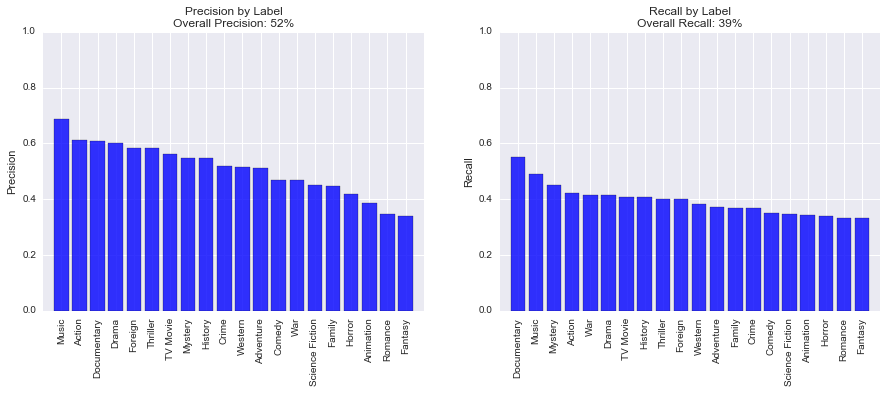

In [304]:
y_pos = np.arange(len(average_precision_np.genre)) + 1

fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 2, 1)

ax1 = plt.bar(y_pos, average_precision_np.data, align='center', alpha=0.8, color='b')
ax1 = plt.xticks(y_pos, average_precision_np.genre, rotation=90)
ax1 = plt.xlim([0,21])
ax1 = plt.ylim([0,1])
ax1 = plt.ylabel('Precision')
ax1 = plt.title('Precision by Label\nOverall Precision: {:.0f}%'.format(mean_precision*100))

ax2 = fig.add_subplot(1, 2, 2)

ax2 = plt.bar(y_pos, recall_score_np.data, align='center', alpha=0.8, color='b')
ax2 = plt.xticks(y_pos, recall_score_np.genre, rotation=90)
ax2 = plt.xlim([0,21])
ax2 = plt.ylim([0,1])
ax2 = plt.ylabel('Recall')
ax2 = plt.title('Recall by Label\nOverall Recall: {:.0f}%'.format(mean_recall*100))

plt.show()